In [1]:
import utils

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
top_categories = utils.find_top_n_categories(df_data, top_n=3)
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

# select a few features to avoid computational issues.
product_features = [
    'Product colour',
    'Format',
    'Width',
    'Height',
    'Maximum capacity',
    'Orientation',
    'Weight',
    'Material',
    'Depth',
    'Media weight',
    'Quantity per pack'
]

In [3]:
df_play_data = df_data[['category_name', 'supplier_name'] + product_features].copy()

In [4]:
df_play_data

category_name supplier_name Product colour Format Width Height  \
83                 Folders         Leitz            Red     A4   NaN    NaN   
3616               Folders         Leitz            NaN    NaN   239    325   
3619               Folders         Leitz            Red     A4   220    310   
3621               Folders         Leitz            NaN     A4   313    220   
3622               Folders         Leitz            Red     A4   220    313   
...                    ...           ...            ...    ...   ...    ...   
5687  Self-Adhesive Labels         Leitz         Orange    NaN   NaN    NaN   
5686  Self-Adhesive Labels         Leitz           Grey    NaN   NaN    NaN   
5684  Self-Adhesive Labels         Leitz          Brown    NaN   NaN    NaN   
5702  Self-Adhesive Labels         Leitz         Yellow    NaN   NaN    NaN   
5902  Self-Adhesive Labels         Epson     Blue, Grey    NaN   NaN    NaN   

     Maximum capacity Orientation Weight            Material Depth  \
83                NaN         NaN    NaN                 NaN   NaN   
3616              NaN         NaN     30              Carton     1   
3619              NaN    Portrait     20           Cardboard   NaN   
3621              NaN         NaN     20  Polypropylene (PP)   NaN   
3622              NaN         NaN     20                 PVC   NaN   
...               ...         ...    ...                 ...   ...   
5687              NaN         NaN     60                 NaN   NaN   
5686              NaN         NaN     60                 NaN   NaN   
5684              NaN         NaN     60                 NaN   NaN   
5702              NaN         NaN     60                 NaN   NaN   
5902              NaN         NaN    NaN                 NaN   NaN   

     Media weight Quantity per pack  
83            NaN               NaN  
3616          NaN               NaN  
3619          NaN               NaN  
3621          NaN               NaN  
3622          NaN               NaN  
...           ...               ...  
5687          NaN               NaN  
5686          NaN               NaN  
5684          NaN               NaN  
5702          NaN               NaN  
5902          NaN               NaN  

[1286 rows x 13 columns]

In [5]:
# Prepare for preprocessing
df_play_cleaned, feature_dtypes = utils.prepare_for_preprocessing(df_play_data)

In [6]:
numeric_features = list(sorted(feature_dtypes['float'] + feature_dtypes['int32']))
categorical_features = feature_dtypes['category']
multi_categorical_features = feature_dtypes['multi-category']
binary_features = feature_dtypes['binary']

# Convert multi-categorical features to list of values.
for c in multi_categorical_features:
    df_play_cleaned[c] = df_play_cleaned[c].astype('str').apply(lambda r: [v.strip() for v in r.split(',')])

In [7]:
# Create data preprocessor
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
multi_categorical_transformer = utils.MultiHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ('nummerical', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features),
        ('multi-categorical', multi_categorical_transformer, multi_categorical_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Preprocess data
X = preprocessor.fit_transform(df_play_cleaned)

In [8]:
X.shape

(1286, 134)

In [9]:
distances = rbf_kernel(X)

In [10]:
distances.shape

(1286, 1286)

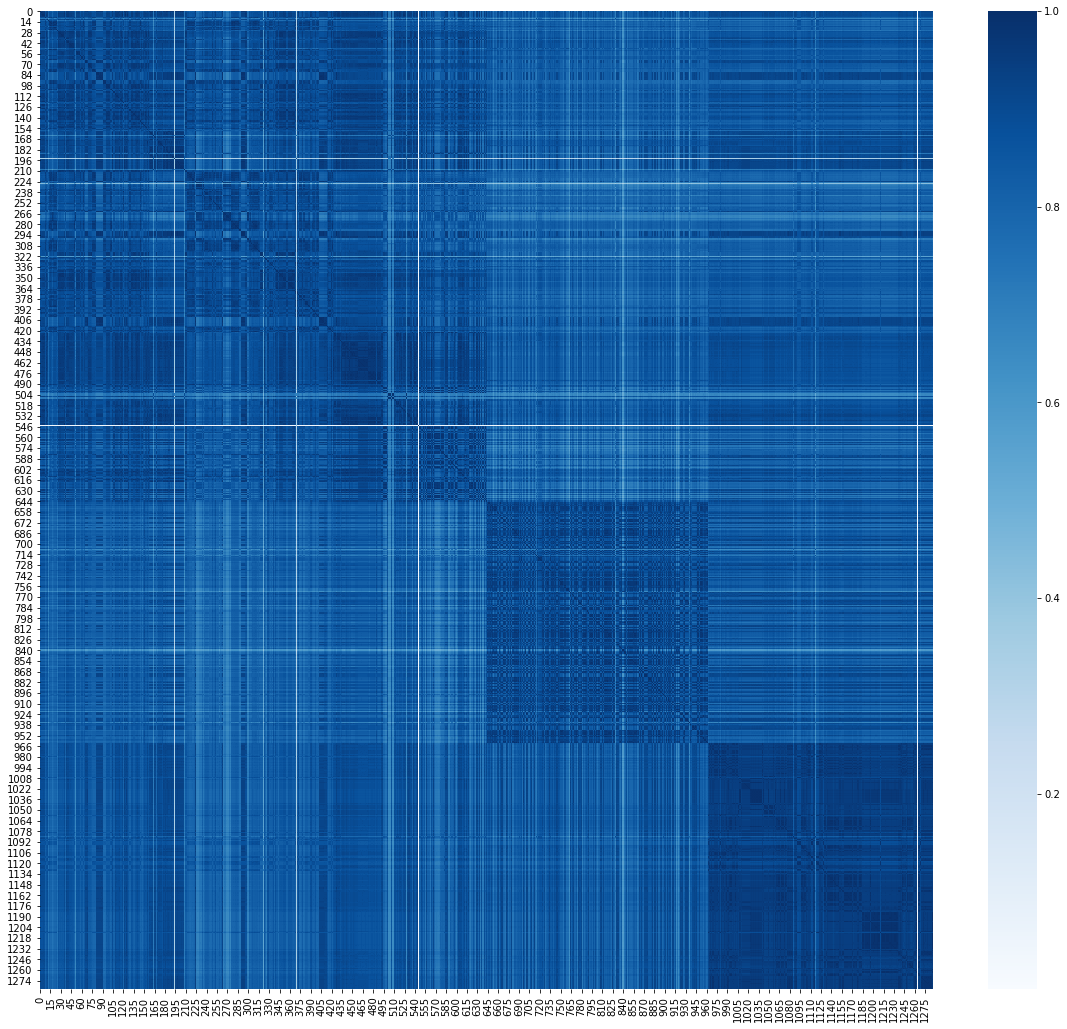

In [11]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(distances, cmap="Blues", ax=ax)
'';

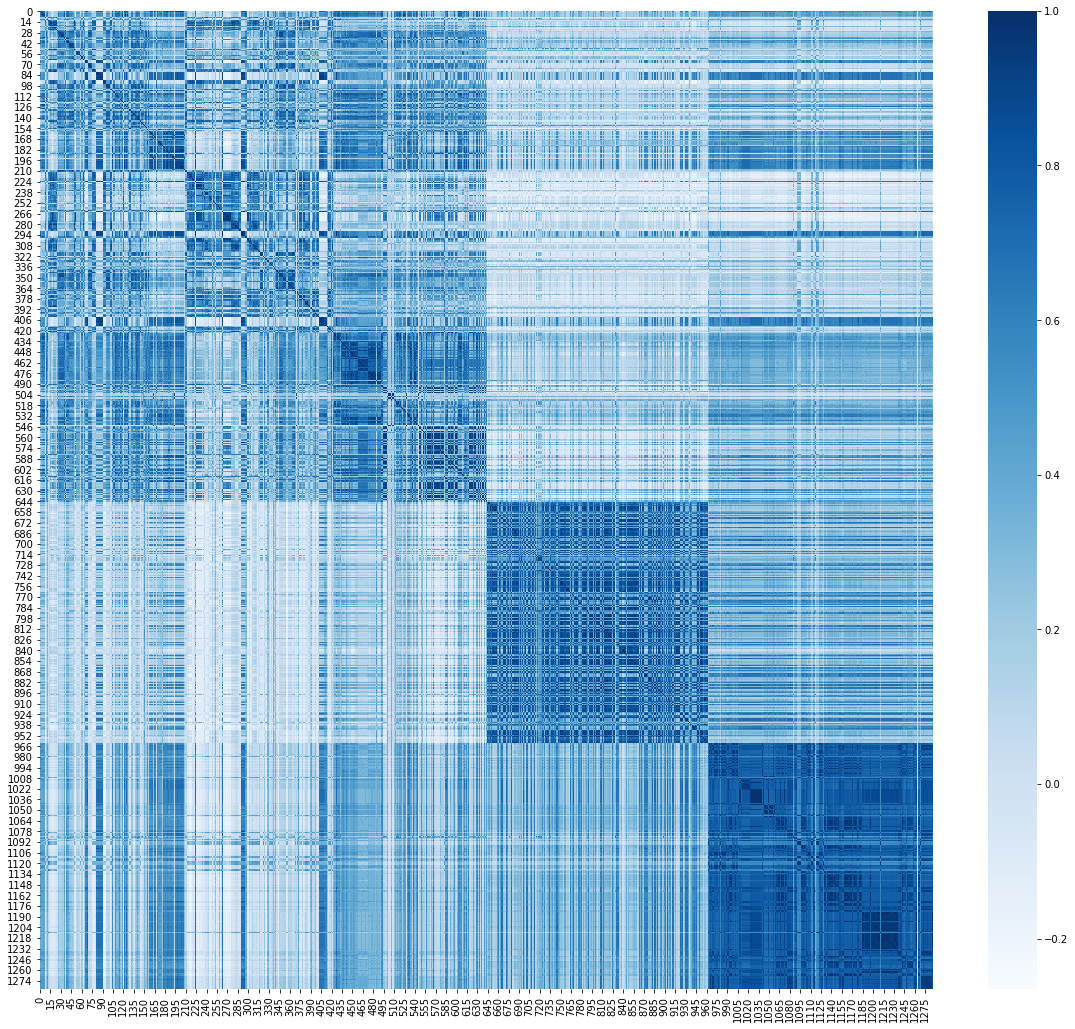

In [12]:
distances = cosine_similarity(X)
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(distances, cmap="Blues", ax=ax)
'';

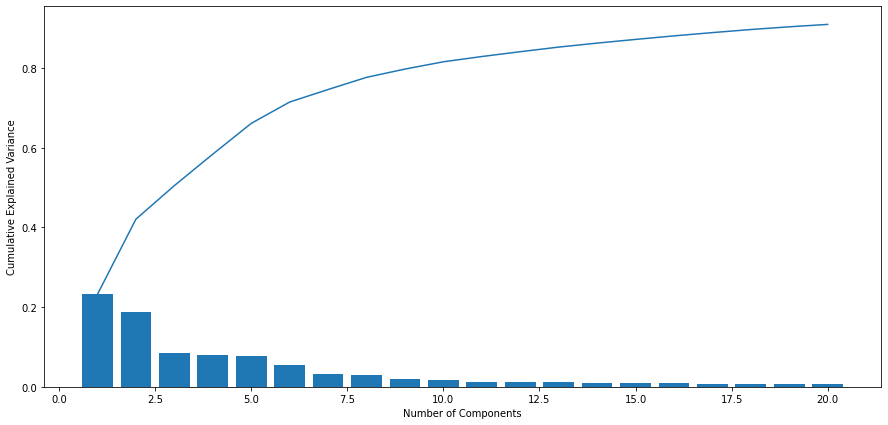

In [13]:
# Further dimensionality reduction
svd = PCA(n_components=20, random_state=42)
X_transformed = svd.fit_transform(X)

# Generate scree plot
utils.create_variance_scree_plot(svd.explained_variance_ratio_)

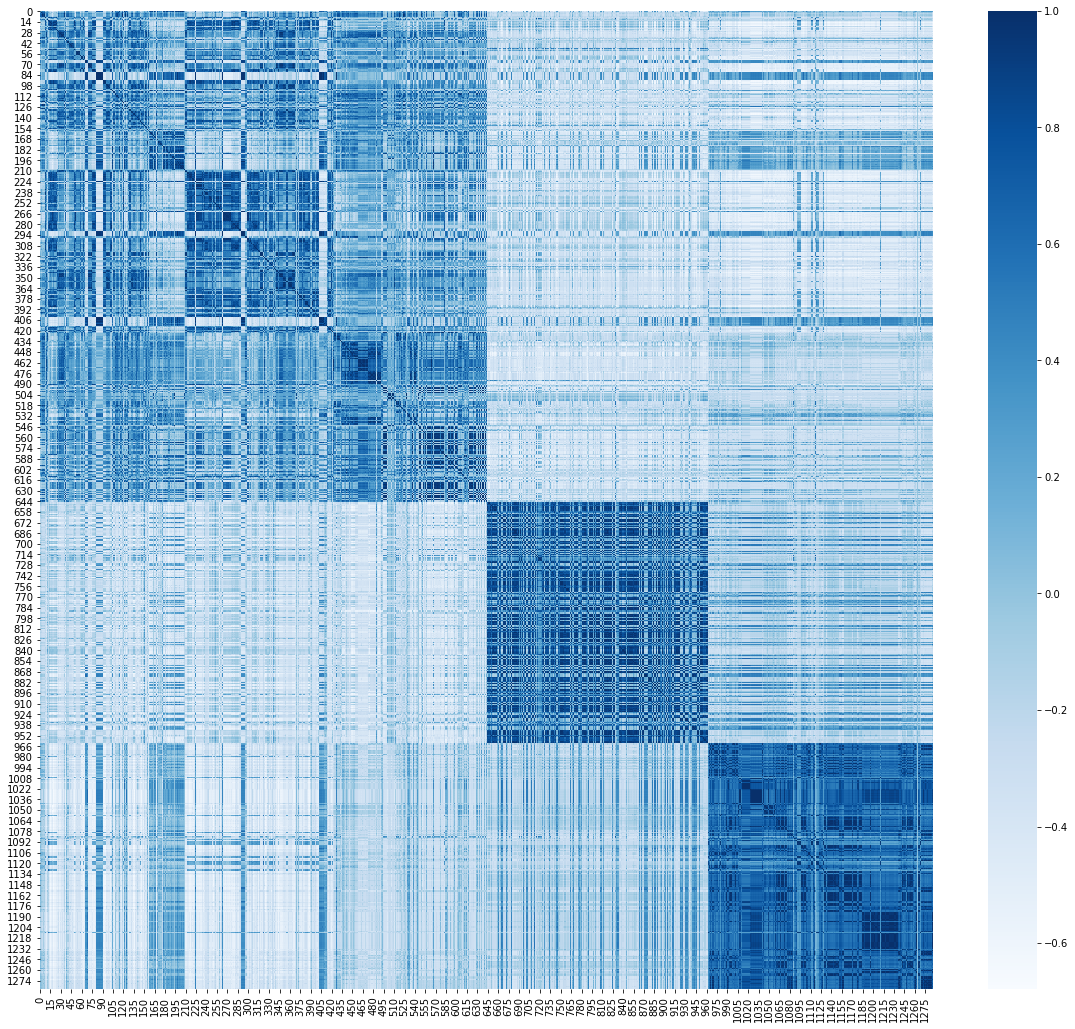

In [14]:
distances = cosine_similarity(X_transformed)
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(distances, cmap="Blues", ax=ax)
'';

## Plotting Products with t-SNE

In [15]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300)
X_2d = tsne.fit_transform(X_transformed)

In [16]:
df_play_cleaned['title'] = df_data['title']
df_play_cleaned['dim1'] = X_2d[:,0]
df_play_cleaned['dim2'] = X_2d[:,1]

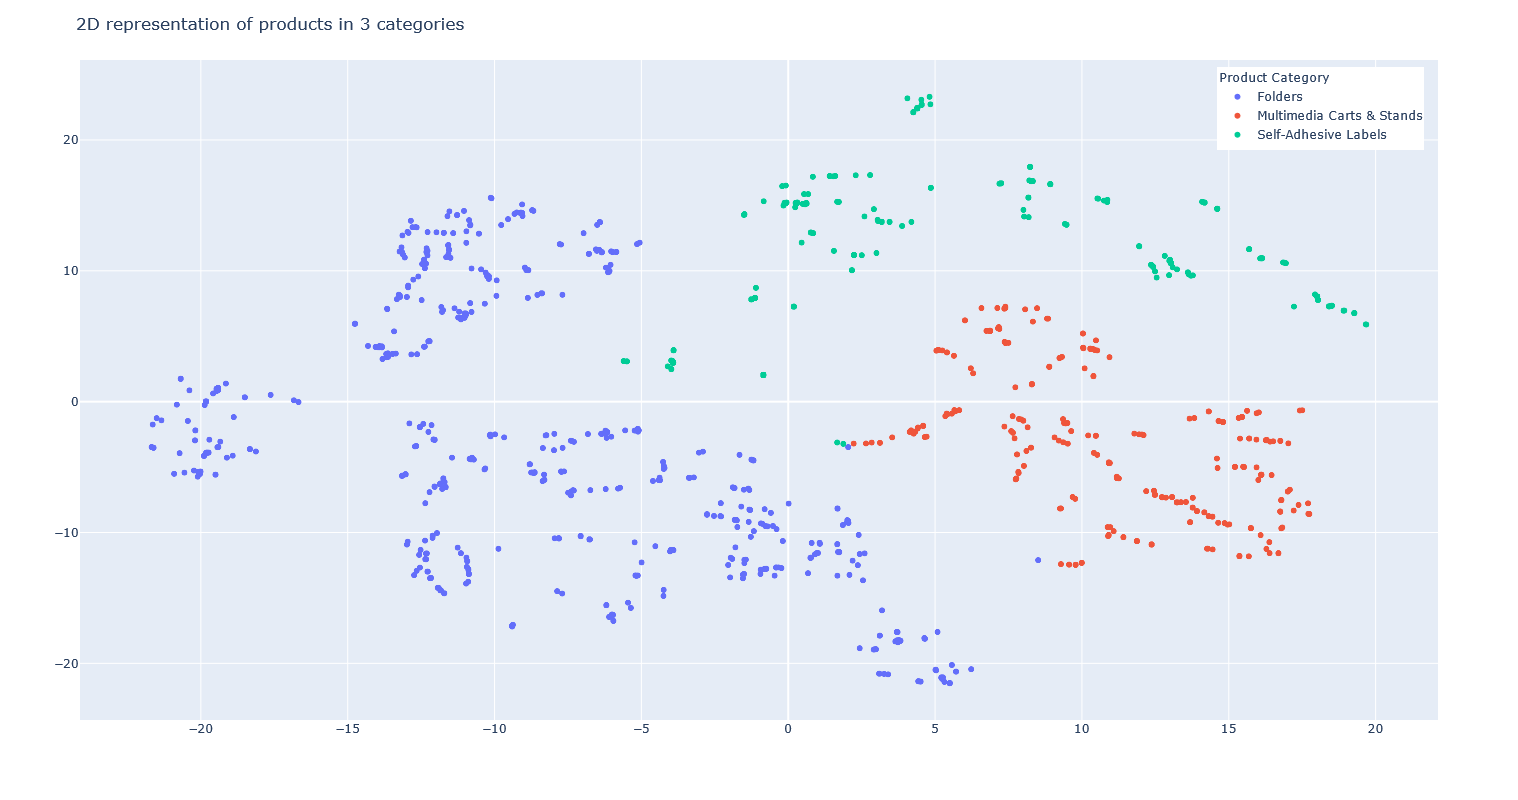

In [17]:
fig = px.scatter(
    df_play_cleaned,
    x="dim1",
    y="dim2",
    color="category_name",
    hover_name="title",
    hover_data={
        "category_name": False, "dim1": False, "dim2": False,
        "Supplier": df_play_cleaned['supplier_name'],
        "Format": True,
        "Weight": True,
        "Orientation": True,
    },
)
fig.update_layout(
    legend=dict(
        title="Product Category",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
    title='2D representation of products in 3 categories',
    autosize=False,
    width=800,
    height=800,
)
fig.update_xaxes(showticklabels=True, title="")
fig.update_yaxes(showticklabels=True, title="")
fig.show()